In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from superfv import OutputLoader

In [2]:
base_path = "/scratch/gpfs/jp7427/out/profiling-2d-square/"

PAD = {"rho": (0, None), "P": (0, None)}
apriori = dict(ZS=True, lazy_primitives="adaptive", PAD=PAD)
aposteriori = dict(MOOD=True, PAD=PAD, lazy_primitives="full", NAD_rtol=0, NAD_atol=0)

configs = {
    "p0": dict(p=0),
    "MUSCL-Hancock": dict(p=1, MUSCL=True, MUSCL_limiter="PP2D"),
    "p3": dict(p=3),
    "p7": dict(p=7),
    "ZS3": dict(p=3, GL=True, **apriori),
    "ZS7": dict(p=7, GL=True, **apriori),
    "ZS3t": dict(p=3, adaptive_dt=False, **apriori),
    "ZS7t": dict(p=7, adaptive_dt=False, **apriori),
    "MM3": dict(p=3, cascade="muscl", skip_trouble_counts=True, **aposteriori),
    "MM7": dict(p=7, cascade="muscl", skip_trouble_counts=True, **aposteriori),
    "MM3-2": dict(p=3, cascade="muscl1", max_MOOD_iters=2, **aposteriori),
    "MM7-2": dict(p=7, cascade="muscl1", max_MOOD_iters=2, **aposteriori),
    "MM3-3": dict(p=3, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
    "MM7-3": dict(p=7, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
}

n_steps = 10
N_values = [64, 128, 256, 512, 1024, 2048]

data = []
for (name, config), N in product(configs.items(), N_values):
    sim_path = f"{base_path}{name}/N_{N}/"
    sim = OutputLoader(sim_path)

    update_rates = sim.minisnapshots["update_rate"]
    entry = dict(config=name, N=N, update_rate=np.mean(update_rates[1:]))
    data.append(entry)
df = pd.DataFrame(data)

Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/p0/N_64"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/p0/N_128"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/p0/N_256"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/p0/N_512"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/p0/N_1024"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/p0/N_2048"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/MUSCL-Hancock/N_64"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/MUSCL-Hancock/N_128"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/MUSCL-Hancock/N_256"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/MUSCL-H

/tmp/ipykernel_930912/649907960.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["config"] = df_filtered["config"].astype(
/tmp/ipykernel_930912/649907960.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for config, df_name in df_sorted.groupby("config"):
/tmp/ipykernel_930912/649907960.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

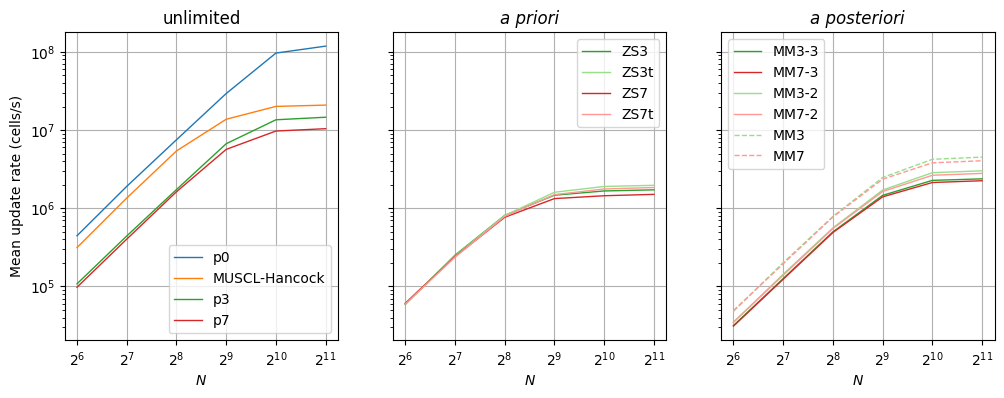

In [7]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
axs[0].set_xscale("log", base=2)
axs[0].set_yscale("log")
axs[0].set_ylabel("Mean update rate (cells/s)")
for i in range(3):
    axs[i].set_xlabel(r"$N$")
    axs[i].grid()
axs[0].set_title("unlimited")
axs[1].set_title("a priori", fontstyle="italic")
axs[2].set_title("a posteriori", fontstyle="italic")

subsets = (
    ["p0", "MUSCL-Hancock", "p3", "p7"],
    ["ZS3", "ZS3t", "ZS7", "ZS7t"],
    ["MM3-3", "MM7-3", "MM3-2", "MM7-2", "MM3", "MM7"],
)

common_style = dict(linewidth=1)

cmap = plt.get_cmap("tab20")
styles = {
    "p0": dict(color=cmap(0)),
    "MUSCL-Hancock": dict(color=cmap(2)),
    "p3": dict(color=cmap(4)),
    "p7": dict(color=cmap(6)),
    "ZS3": dict(color=cmap(4)),
    "ZS7": dict(color=cmap(6)),
    "ZS3t": dict(color=cmap(5)),
    "ZS7t": dict(color=cmap(7)),
    "MM3-3": dict(color=cmap(4)),
    "MM7-3": dict(color=cmap(6)),
    "MM3-2": dict(color=cmap(5)),
    "MM7-2": dict(color=cmap(7)),
    "MM3": dict(color=cmap(5), linestyle="--"),
    "MM7": dict(color=cmap(7), linestyle="--"),
}

for i, subset in enumerate(subsets):
    df_filtered = df[df["config"].isin(subset)]
    df_filtered["config"] = df_filtered["config"].astype(
        pd.CategoricalDtype(subset, ordered=True)
    )
    df_sorted = df_filtered.sort_values(by=["config", "N"])

    for config, df_name in df_sorted.groupby("config"):
        axs[i].plot(
            df_name["N"],
            df_name["update_rate"],
            label=config,
            **common_style,
            **styles[config],
        )

    axs[i].legend()

In [8]:
fig.savefig("../../timing.png", dpi=300)